<h3>Import statements</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<h3>Data Loading and Preprocessing</h3>

In [2]:
# Load the data
df = pd.read_parquet('data.parquet') 

print(df.shape)
print(df.isnull().sum()) 
df.head()

(690512, 3)
banknifty    1500
nifty        2000
tte             0
dtype: int64


,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [3]:
print(df.isnull().sum())

#Fill in the NaN or Inf values with a KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

# Verify if NaN or Inf values are removed
print(df.isnull().sum())

banknifty    1500
nifty        2000
tte             0
dtype: int64
banknifty    0
nifty        0
tte          0
dtype: int64


Text(0, 0.5, 'Spread')

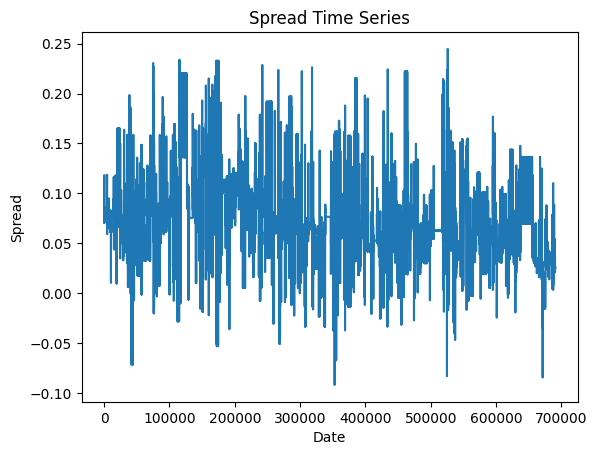

In [4]:
# Calculate the spread 
df['Spread'] = df['banknifty'] - df['nifty']

# Visualize the spread
plt.plot(df['Spread'])
plt.title('Spread Time Series')
plt.xlabel('Date')
plt.ylabel('Spread')

<h3>Z-Score Model</h3>

In [5]:
# Base Model - Z-score strategy

roll_mean = df['Spread'].rolling(window=20).mean()
roll_std = df['Spread'].rolling(window=20).std()
df['Z-Score'] = (df['Spread'] - roll_mean)/roll_std

df['Signal'] = 0 
df.loc[df['Z-Score'] > 1, 'Signal'] = 1 
df.loc[df['Z-Score'] < -1, 'Signal'] = -1 

df['PL'] = df['Spread'] * (df['tte'])**0.7

cumulative_pl = df['PL'].cumsum()
cumulative_max = cumulative_pl.cummax()
drawdown = cumulative_max - cumulative_pl

drawdown_start = drawdown[drawdown == 0].index
drawdown_end = cumulative_max.idxmax()
drawdown_duration = drawdown_end - drawdown_start

print('Base Model Performance:')
print('Total P/L:', df['PL'].sum())
print('Sharpe Ratio:', df['PL'].mean() / df['PL'].std() * np.sqrt(252))
print('Max Drawdown:', drawdown.max())
print('Max Drawdown Duration:', drawdown_duration.max())
print('Number of Trades:', df['Signal'].abs().sum()) 
print('Hit Ratio:', (df['Signal'].diff() == 2).sum() / df['Signal'].abs().sum())
print('Average Holding Period:', df['Signal'].abs().sum() / (df['Signal'].diff() == 2).sum()) 

Base Model Performance:
Total P/L: 319335.2072536706
Sharpe Ratio: 27.76694371334243
Max Drawdown: 0.9245116120146122
Max Drawdown Duration: 690511
Number of Trades: 47352
Hit Ratio: 0.012882243622233485
Average Holding Period: 77.62622950819672


<h3>Holt-Winters Exponential Smoothing</h3>

Holt-Winters Model Performance:
Total P/L: 319335.2072536706
Sharpe Ratio: 27.76694371334243
Max Drawdown: 0.9245116120146122
Max Drawdown Duration: 690511
Number of Trades: 1381
Hit Ratio: 0.008689355539464157
Average Holding Period: 115.08333333333333


Text(0, 0.5, 'Spread')

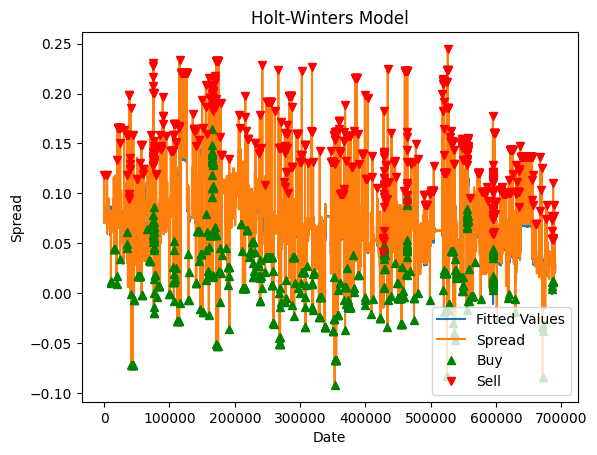

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['Spread'], trend='add', seasonal='add', seasonal_periods=50)

result = model.fit(smoothing_level=0.1, smoothing_slope=0.1, smoothing_seasonal=0.1)

df['Fitted_Values'] = result.fittedvalues
df['Z-Score'] = (df['Spread'] - result.fittedvalues) / result.fittedvalues.std()

df['Signal'] = np.where(df['Z-Score'] > 1.5, -1, np.where(df['Z-Score'] < -1.5, 1, 0))

df['PL'] = df['Spread'] * (df['tte'])**0.7
cumulative_pl = df['PL'].cumsum()
cumulative_max = cumulative_pl.cummax()
drawdown = cumulative_max - cumulative_pl
drawdown_start = drawdown[drawdown == 0].index
drawdown_end = cumulative_max.idxmax()
drawdown_duration = drawdown_end - drawdown_start

print('Holt-Winters Model Performance:')
print('Total P/L:', df['PL'].sum())
print('Sharpe Ratio:', df['PL'].mean() / df['PL'].std() * np.sqrt(252))
print('Max Drawdown:', drawdown.max())
print('Max Drawdown Duration:', drawdown_duration.max())
print('Number of Trades:', df['Signal'].abs().sum())
print('Hit Ratio:', (df['Signal'].diff() == 2).sum() / df['Signal'].abs().sum())
print('Average Holding Period:', df['Signal'].abs().sum() / (df['Signal'].diff() == 2).sum())

plt.plot(df['Fitted_Values'], label='Fitted Values')
plt.plot(df['Spread'], label='Spread')
plt.plot(df[df['Signal'] == 1].index, df['Spread'][df['Signal'] == 1], '^', color='g', label='Buy')
plt.plot(df[df['Signal'] == -1].index, df['Spread'][df['Signal'] == -1], 'v', color='r', label='Sell')
plt.legend(loc='best')
plt.title('Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Spread')

<h3> Holt-Winters Ensemble </h3>

Ensemble Model Performance:
Total P/L: 319335.2072536706
Sharpe Ratio: 27.76694371334243
Max Drawdown: 0.9245116120146122
Max Drawdown Duration: 690511
Number of Trades: 690512
Hit Ratio: 0.06789165141228537
Average Holding Period: 14.729351535836177


Text(0, 0.5, 'Spread')

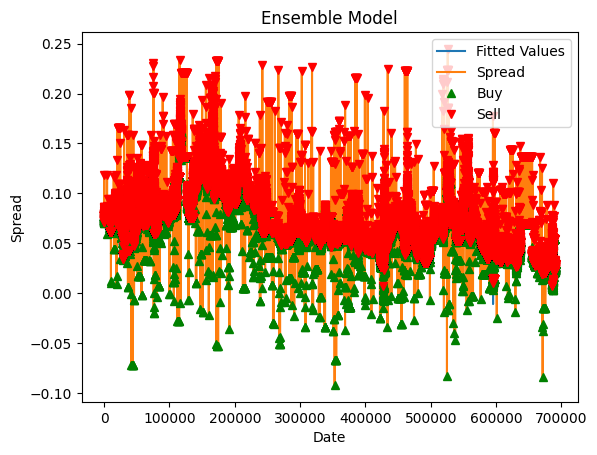

In [9]:
num_models = 5

ensemble_models = []

for i in range(num_models):
    model = ExponentialSmoothing(df['Spread'], trend='add', seasonal='add', seasonal_periods=50)
    result = model.fit(smoothing_level=0.1, smoothing_slope=0.1, smoothing_seasonal=0.1)
    ensemble_models.append(result)

z_scores = []


for i in range(num_models):
    z_score = (df['Spread'] - ensemble_models[i].fittedvalues) / ensemble_models[i].fittedvalues.std()
    z_scores.append(z_score)

z_scores_df = pd.DataFrame(z_scores).T

z_scores_df['Mean_Z-Score'] = z_scores_df.mean(axis=1)

z_scores_df['Std'] = z_scores_df.std(axis=1)

z_scores_df['Ensemble_Z-Score'] = z_scores_df['Mean_Z-Score'] / z_scores_df['Std']

df['Signal'] = np.where(z_scores_df['Ensemble_Z-Score'] > 1.5, -1, np.where(z_scores_df['Ensemble_Z-Score'] < -1.5, 1, 0))

df['PL'] = df['Spread'] * (df['tte'])**0.7
cumulative_pl = df['PL'].cumsum()
cumulative_max = cumulative_pl.cummax()
drawdown = cumulative_max - cumulative_pl
drawdown_start = drawdown[drawdown == 0].index
drawdown_end = cumulative_max.idxmax()
drawdown_duration = drawdown_end - drawdown_start

print('Ensemble Model Performance:')
print('Total P/L:', df['PL'].sum())
print('Sharpe Ratio:', df['PL'].mean() / df['PL'].std() * np.sqrt(252))
print('Max Drawdown:', drawdown.max())
print('Max Drawdown Duration:', drawdown_duration.max())
print('Number of Trades:', df['Signal'].abs().sum())
print('Hit Ratio:', (df['Signal'].diff() == 2).sum() / df['Signal'].abs().sum())
print('Average Holding Period:', df['Signal'].abs().sum() / (df['Signal'].diff() == 2).sum())

plt.plot(df['Fitted_Values'], label='Fitted Values')
plt.plot(df['Spread'], label='Spread')
plt.plot(df[df['Signal'] == 1].index, df['Spread'][df['Signal'] == 1], '^', color='g', label='Buy')
plt.plot(df[df['Signal'] == -1].index, df['Spread'][df['Signal'] == -1], 'v', color='r', label='Sell')
plt.legend(loc='best')
plt.title('Ensemble Model')
plt.xlabel('Date')
plt.ylabel('Spread')

